In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../data/sunspot.txt', delimiter=r"\s+", names=['Year','Jan', 'Feb', 'Mar', 'Apl', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
df.head()

,Year,Jan,Feb,Mar,Apl,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1749,58.0,62.6,70.0,55.7,85.0,83.5,94.8,66.3,75.9,75.5,158.6,85.2
1,1750,73.3,75.9,89.2,88.3,90.0,100.0,85.4,103.0,91.2,65.7,63.3,75.4
2,1751,70.0,43.5,45.3,56.4,60.7,50.7,66.3,59.8,23.5,23.2,28.5,44.0
3,1752,35.0,50.0,71.0,59.3,59.7,39.6,78.4,29.3,27.1,46.6,37.6,40.0
4,1753,44.0,32.0,45.7,38.0,36.0,31.7,22.0,39.0,28.0,25.0,20.0,6.7


In [3]:
df.describe()

,Year,Jan,Feb,Mar,Apl,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
count,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000
mean,1881.500000,49.941353,51.779323,50.982707,51.674060,52.930827,52.452256,52.541729,53.181203,52.692481,52.910150,51.675564,52.399624
std,76.931788,43.705655,43.078891,41.188720,42.896057,44.695856,43.681790,44.227086,45.999958,46.154334,44.451869,43.590282,45.707953
min,1749.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1815.250000,14.775000,15.750000,15.150000,16.275000,18.850000,15.450000,16.425000,16.475000,14.525000,16.950000,15.900000,17.075000
50%,1881.500000,40.650000,43.550000,45.850000,41.000000,41.950000,41.150000,42.200000,40.850000,42.550000,46.300000,40.700000,41.200000
75%,1947.750000,71.350000,75.825000,73.925000,75.700000,76.925000,81.000000,77.825000,76.200000,77.750000,75.500000,76.825000,77.125000
max,2014.000000,217.400000,182.300000,190.700000,196.000000,238.900000,200.700000,191.400000,200.300000,235.800000,253.800000,210.900000,239.400000


In [4]:
matrix = df.values
_df_matrix = []
for row in matrix:
    for i in range(1,13):
        entry = [int(row[0]), row[i]]
        _df_matrix.append(entry)

_df_matrix = np.array(_df_matrix)

_df = pd.DataFrame(_df_matrix)

_df.columns = ['year', 'value']


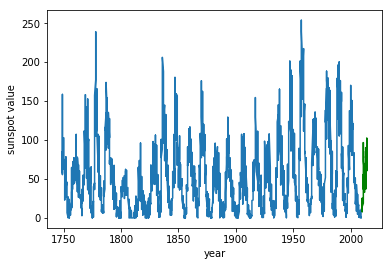

In [5]:
# Test set: 5 recent years [2010 ~ 2014]
# 5 * 12 = 60
# Last 60 rows

years_test = _df_matrix[-60:,0]
sunspots_values_test = _df_matrix[-60:,1]

years_train = _df_matrix[:-60,0]
sunspots_values_train = _df_matrix[:-60,1]

plt.plot(years_train, sunspots_values_train)
plt.plot(years_test, sunspots_values_test, 'g')
plt.xlabel('year')
plt.ylabel('sunspot value')
plt.show()

In [6]:
def generate_phi(data, K):
    phi = []
    for i in range(len(data) - K):
        phi_x = np.insert(np.flip(data[i:i + K]), 0, 1)
        phi.append(phi_x)
    return np.array(phi)

def generate_y(data, K):
    y = []
    for i in range(K, len(data)):
        y.append(data[i])
    return y

In [7]:
phi = generate_phi(_df.values[:-60,1], 20)
y = generate_y(_df.values[:-60,1], 20)
w = np.dot(np.dot(np.linalg.inv(np.dot(phi.T, phi)), phi.T), y)

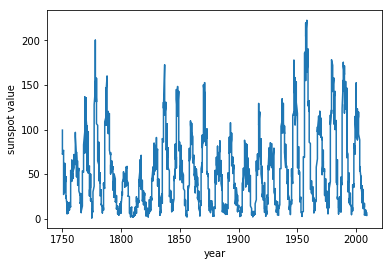

In [8]:
plt.plot(years_train[20:], np.dot(phi,w) )
plt.xlabel('year')
plt.ylabel('sunspot value')
plt.show()

In [9]:
last_train_subset = sunspots_values_train[-20:]

In [10]:
def predict_x_next(train_subset, w, X, K):
    predicted_values = []
    for i in range(X):
        features = np.insert(np.flip(train_subset[i:]), 0, 1).T
        predicted_value = np.dot(features, w)
        train_subset = np.append(train_subset, predicted_value)
        predicted_values.append(predicted_value)
        
    return predicted_values

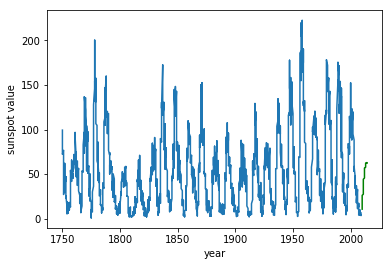

In [11]:
predictions = predict_x_next(last_train_subset, w, 60, 20)

plt.plot(years_train[20:], np.dot(phi,w) )
plt.plot(years_test, predictions, 'g' )
plt.xlabel('year')
plt.ylabel('sunspot value')
plt.show()

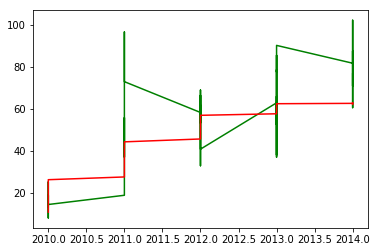

In [12]:
plt.plot(years_test, sunspots_values_test, 'g')
plt.plot(years_test, predictions, 'r')

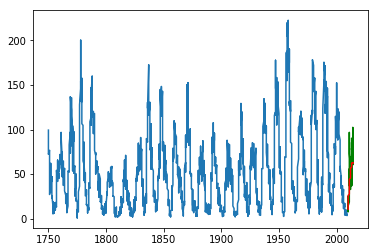

In [13]:
plt.plot(years_train[20:], np.dot(phi,w) )
plt.plot(years_test, sunspots_values_test, 'g')
plt.plot(years_test, predictions, 'r')

In [14]:
rmse = lambda predictions, sunspots_values_test: np.sqrt(np.sum(predictions - sunspots_values_test)**2) * 1/len(predictions)

rmse(predictions, sunspots_values_test)

8.900682833206169